# Qooked Tahoe Quatum Challenge 2025

## Forest Simulation

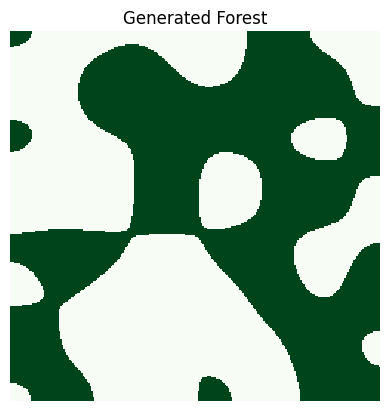

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, gaussian_filter, distance_transform_edt
import time

EMPTY, TREE = 0, -1

def generate_clumpy_forest(size=250, clump_scale=35, tree_ratio=0.5, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Ensure clump_scale results in an integer low_res_size
    low_res_size = max(1, int(size // clump_scale))  # Force integer by casting to int

    # Generate very low-res noise to create large clumps
    noise = np.random.rand(low_res_size, low_res_size)

    # Bicubic upscaling to smooth the clumps
    smooth_noise = zoom(noise, size / low_res_size, order=3)
    smooth_noise = smooth_noise[:size, :size]

    # Threshold to split TREE vs EMPTY while maintaining tree_ratio
    threshold = np.percentile(smooth_noise, 100 * (1 - tree_ratio))

    # Create forest matrix using TREE = -1 and EMPTY = 0
    forest = np.full((size, size), EMPTY)
    forest[smooth_noise > threshold] = TREE

    return forest

# Only run this if Forest.py is run directly, not when it's imported
size = 250
forest = generate_clumpy_forest(size, clump_scale=30.0)

# Visualization (this won't run when imported in Forest_City.py)
plt.imshow(forest, cmap="Greens", interpolation="nearest")
plt.title("Generated Forest")
plt.axis("off")
plt.show()

## City Simulation

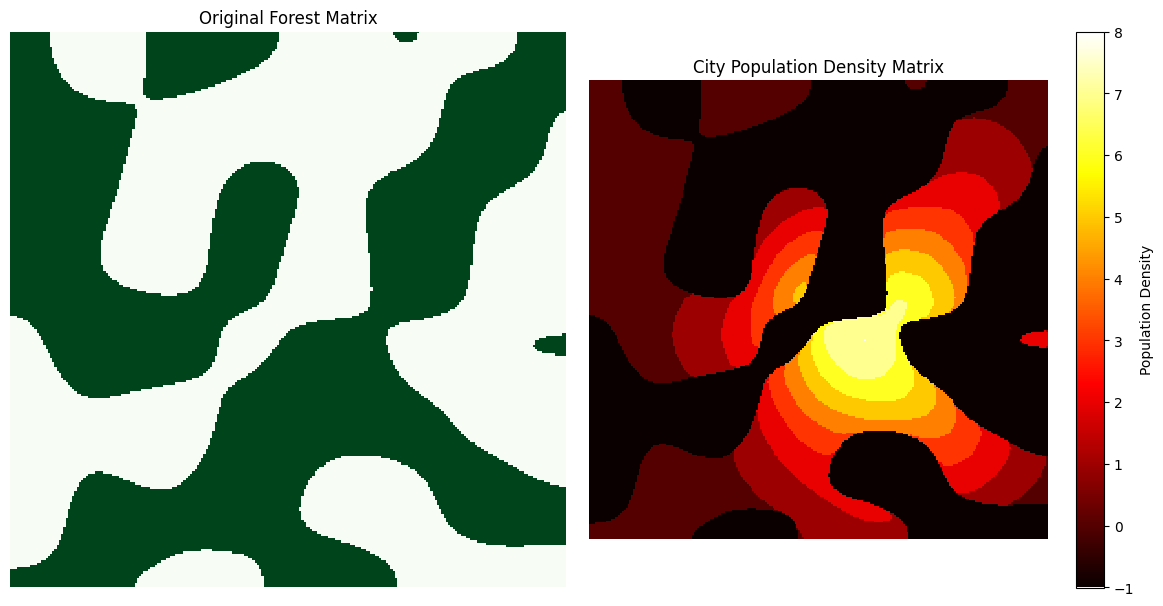

In [2]:
def generate_large_cluster_city_matrix(size, forest_matrix, smoothness=10.0, distance_influence=2.0, center_bias=2.0):
    # Step 1: Random noise, smoothed
    raw_noise = np.random.rand(size, size)
    smoothed = gaussian_filter(raw_noise, sigma=smoothness)

    # Step 2: Distance from trees
    tree_mask = (forest_matrix == TREE)
    distance_map = distance_transform_edt(~tree_mask)

    # Step 3: Distance from center (bias toward center)
    y, x = np.indices((size, size))
    center_y, center_x = size // 2, size // 2
    dist_to_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    center_bias_map = 1 - (dist_to_center / dist_to_center.max())  # 1 at center, 0 at corners

    # Step 4: Normalize input maps
    smoothed_norm = (smoothed - smoothed.min()) / (smoothed.max() - smoothed.min())
    distance_norm = (distance_map - distance_map.min()) / (distance_map.max() - distance_map.min())

    # Step 5: Combine factors
    biased_density = smoothed_norm * (distance_norm ** distance_influence) * (center_bias_map ** center_bias)

    # Step 6: Scale to 1–8, threshold very low values to 0 (no pop), and set trees to -1
    scaled_density = (biased_density / biased_density.max()) * 8
    city_matrix = scaled_density.astype(int)
    city_matrix[city_matrix < 1] = 0         # No population
    city_matrix[tree_mask] = -1              # Forest cells

    return city_matrix

def print_matrix(matrix):
    for row in matrix:
        print(" ".join(str(cell) for cell in row))

# Example usage

size = 250
smoothness = 50.0
distance_influence = 0.05  # Tune this between 1.0 (mild) and 3.0 (strong effect)
center_bias = 1.3  # center preference
forest = generate_clumpy_forest(size, clump_scale=30.0)
city = generate_large_cluster_city_matrix(size, forest, smoothness, distance_influence, center_bias)

# Optional: visualize both matrices
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(forest, cmap="Greens", interpolation="nearest")
plt.title("Original Forest Matrix")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(city, cmap="hot", interpolation="nearest")
plt.title("City Population Density Matrix")
plt.colorbar(label="Population Density")
plt.axis('off')

plt.tight_layout()
plt.show()

## Fire Simulation

Enter the number of timesteps (default is 250):  200


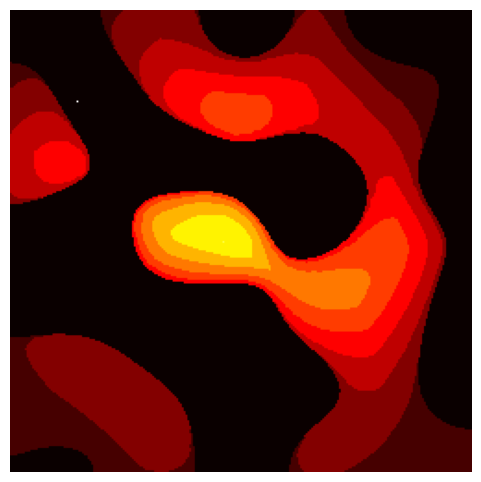

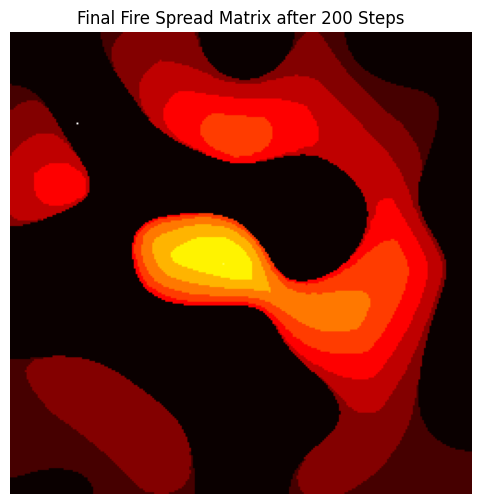

Final fire spread matrix (last timestep):
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ...  0  0  0]
 [-1 -1 -1 ...  0  0  0]
 [-1 -1 -1 ...  0  0  0]]


In [3]:
# Constants for visualization
TREE = -1
FIRE = 100  # Arbitrary high value that won't overlap population values

# Parameters (default values)
GRID_SIZE = 250
TREE_SPREAD_PROB = 0.35
EMPTY_SPREAD_PROB = 0.02
SPREAD_DENSITY_SCALE = 0.55  # Tune this value to control influence of population density
BURN_DURATION = 10
DEFAULT_STEPS = 250

def wind_vector_components(angle_degrees):
    """Convert angle in degrees (0 = right, 90 = up) to normalized (dy, dx)."""
    radians = np.radians(angle_degrees)
    return -np.sin(radians), np.cos(radians)

class FireGrid:
    def __init__(self, forest_city_matrix):
        self.grid = forest_city_matrix.copy()
        self.fire_time = np.zeros_like(self.grid, dtype=int)

        # Find a TREE to ignite
        tree_indices = np.argwhere(self.grid == TREE)

        # Check if tree_indices is empty
        if len(tree_indices) == 0:
            raise ValueError("No trees found in the city matrix. Ensure that your city matrix contains trees marked by the TREE constant.")

        # Randomly select a tree to ignite
        y, x = tree_indices[np.random.choice(len(tree_indices))]  # Randomly select a tree to ignite
        self.grid[y, x] = FIRE
        self.fire_time[y, x] = 1

    def step(self):
        new_grid = self.grid.copy()
        new_fire_time = self.fire_time.copy()

        fire_yx = np.argwhere(self.grid == FIRE)
        for y, x in fire_yx:
            # Burned out?
            if self.fire_time[y, x] >= BURN_DURATION:
                new_grid[y, x] = 0  # Becomes EMPTY
                new_fire_time[y, x] = 0
                continue

            new_fire_time[y, x] += 1

            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dy == 0 and dx == 0:
                        continue
                    ny, nx = y + dy, x + dx
                    if 0 <= ny < self.grid.shape[0] and 0 <= nx < self.grid.shape[1]:
                        target = self.grid[ny, nx]

                        # Spread fire to trees
                        if target == TREE and np.random.random() < TREE_SPREAD_PROB:
                            new_grid[ny, nx] = FIRE
                            new_fire_time[ny, nx] = 1
                        # Spread fire to non-tree areas based on population density
                        elif target != FIRE and target != TREE:
                            # Calculate spread probability based on population density
                            population_density = self.grid[ny, nx]
                            if population_density == 0:
                                prob = EMPTY_SPREAD_PROB  # Regular empty land
                            else:
                                # Slightly increase spread probability based on population density
                                prob = EMPTY_SPREAD_PROB * (1 + population_density * SPREAD_DENSITY_SCALE)

                            if np.random.random() < prob:
                                new_grid[ny, nx] = FIRE
                                new_fire_time[ny, nx] = 1

        self.grid = new_grid
        self.fire_time = new_fire_time

    def visualize(self, step, imshow_obj):
        # Prepare grid for display
        display_grid = self.grid.copy()
        display_grid[display_grid == TREE] = -1
        display_grid[display_grid == FIRE] = 10  # Just a high value to make it visibly distinct

        # Update the imshow object with the new grid data
        imshow_obj.set_array(display_grid)

    def get_final_grid(self):
        return self.grid

# EXAMPLE USAGE

user_steps = int(input(f"Enter the number of timesteps (default is {DEFAULT_STEPS}): "))

# Build forest-city combo matrix
forest = generate_clumpy_forest(GRID_SIZE, clump_scale=35, tree_ratio=0.5)
forest_city = generate_large_cluster_city_matrix(GRID_SIZE, forest, smoothness=50, distance_influence=0.2, center_bias=1.3)

# Initialize the fire simulation
fire_sim = FireGrid(forest_city)

# Create the figure and initial imshow object
fig, ax = plt.subplots(figsize=(6, 6))
imshow_obj = ax.imshow(fire_sim.grid, cmap="hot", vmin=-1, vmax=10)
ax.axis('off')

# After all steps, return the final grid (this is the final matrix)
final_matrix = fire_sim.get_final_grid()

# Display the final matrix after the simulation ends
plt.figure(figsize=(6, 6))
plt.imshow(final_matrix, cmap="hot", vmin=-1, vmax=10)
plt.title(f"Final Fire Spread Matrix after {user_steps} Steps")
plt.axis('off')  # Hide axes for cleaner visualization
plt.show()

# Return the final grid for further analysis or processing
print("Final fire spread matrix (last timestep):")
print(final_matrix)

## fire threat

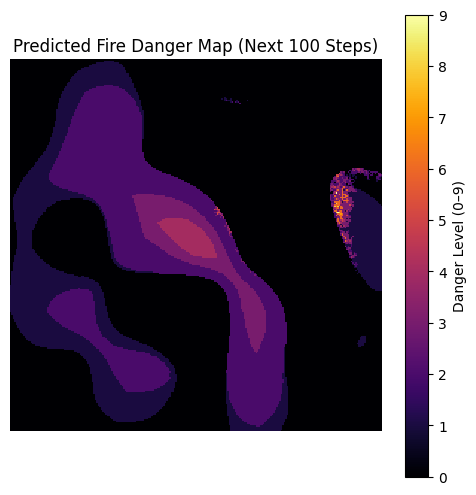

In [4]:
def normalize(matrix):
    max_val = matrix.max()
    return matrix / max_val if max_val > 0 else matrix

def predict_fire_threat():
    random_seed = int(time.time())
    np.random.seed(random_seed)

    GRID_SIZE = 250
    FUTURE_STEPS = 100

    # Generate environment with random seed
    forest = generate_clumpy_forest(GRID_SIZE, clump_scale=35, tree_ratio=0.5, seed=random_seed)
    city = generate_large_cluster_city_matrix(GRID_SIZE, forest, smoothness=50, distance_influence=0.2, center_bias=1.3)
    city_with_forest = city.copy()
    city_with_forest[forest == 1] = TREE

    fire_sim = FireGrid(city_with_forest)

    # Create figure for animation
    fig, ax = plt.subplots(figsize=(6, 6))  # Create a 6x6 inch figure
    imshow_obj = ax.imshow(fire_sim.grid, cmap="hot", vmin=-1, vmax=10)  # Display the grid, color-mapped with 'hot' colormap
    ax.axis('off')  # Turn off the axis for the visualization

    plt.close(fig)  # Closes the fire animation window after it's done

    # Compute population-weighted future fire danger
    pop_fire_danger = np.zeros_like(fire_sim.grid, dtype=float)
    burn_frequency = np.zeros_like(fire_sim.grid, dtype=float)

    for _ in range(FUTURE_STEPS):
        fire_sim.step()
        burning_now = (fire_sim.grid == FIRE)
        
        # Add population-weighted burning to danger
        pop_fire_danger += burning_now * city
        burn_frequency += burning_now.astype(float)

    # Normalize all components
    fire_component = normalize(pop_fire_danger)         # Most important
    forest_component = normalize((forest == 1).astype(float))
    city_component = normalize(city.astype(float))

    # ⚖️ weight of things burned
    total_danger = (
        1.5 * fire_component +     # population burned 
        1 * forest_component +   # forest presence 
        0.75 * city_component       # overall population 
    )

    # ✅ Normalize final danger matrix before scaling
    normalized_total_danger = normalize(total_danger)
    scaled_danger = np.round(normalized_total_danger * 9).clip(0, 9).astype(int)

    # Final display
    plt.figure(figsize=(6, 6))
    plt.imshow(scaled_danger, cmap="inferno", interpolation="nearest")
    plt.title("Predicted Fire Danger Map (Next 100 Steps)")
    plt.axis("off")
    plt.colorbar(label="Danger Level (0–9)")
    plt.show()

    return scaled_danger, fire_sim.fire_time, city, forest

danger_map, fire_timeline, city, forest = predict_fire_threat()

## Optimizing Resource Allocation

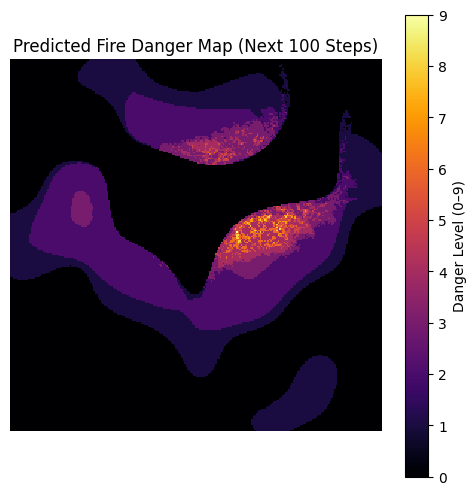

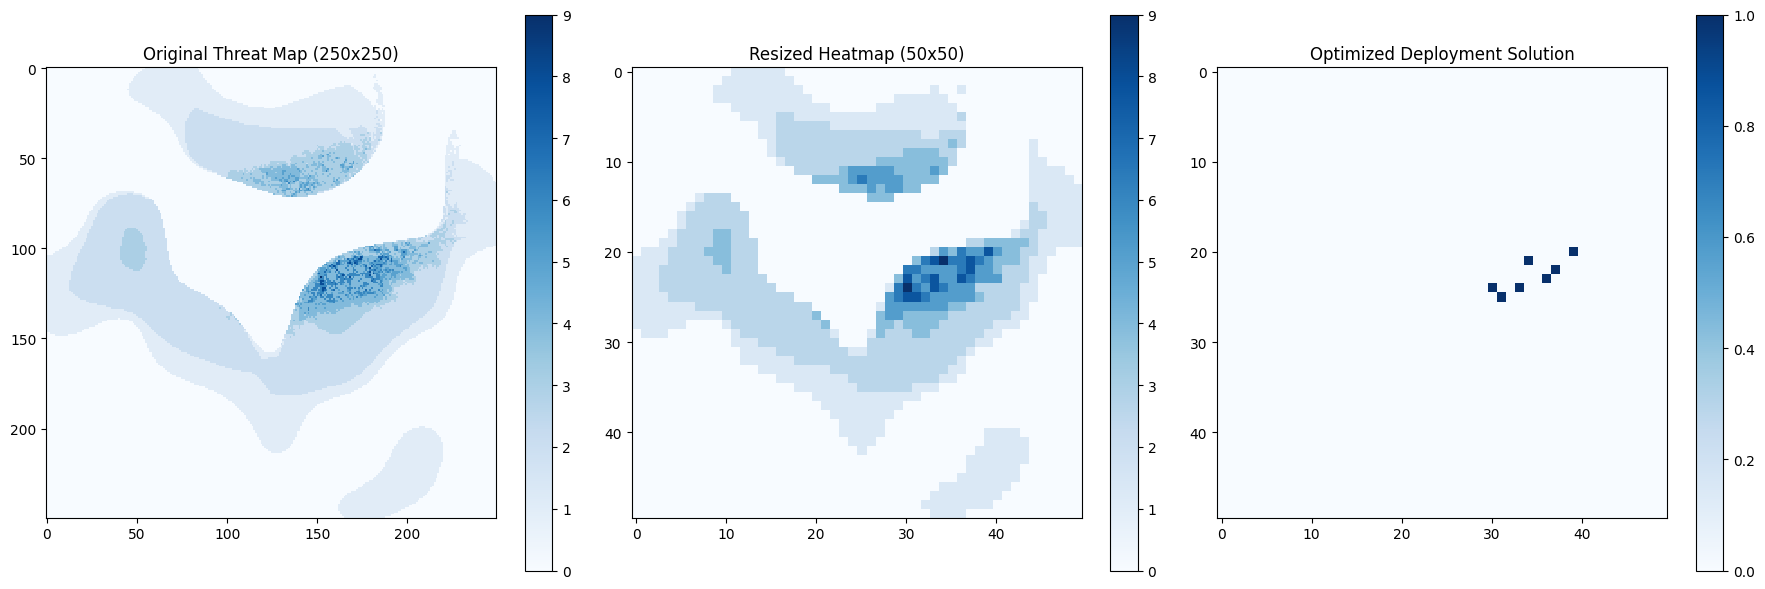

Optimal Response Deployment:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Energy (QUBO Objective): -7.571428571428568
Units used: 7


In [5]:
from pyqubo import Binary
from neal import SimulatedAnnealingSampler

# Function to resize the danger map to a 50x50 format directly
def resize_heatmap(original_map, target_size=50):
    """Resizes and rescales the original danger map to target size using interpolation."""
    h, w = original_map.shape
    resized_map = zoom(original_map, (target_size / h, target_size / w), order=1)  # Bilinear interpolation

    # Normalize to 0–9 range
    min_val, max_val = resized_map.min(), resized_map.max()
    if max_val > min_val:
        resized_map = (resized_map - min_val) / (max_val - min_val) * 9
    else:
        resized_map = np.zeros_like(resized_map)

    return resized_map

# QUBO conversion function
def matrix_to_qubo(matrix, alpha=2, beta=4, allow_adjacent_penalty=True):
    n = matrix.shape[0]
    variables = {}

    for i in range(n):
        for j in range(n):
            variables[(i, j)] = Binary(f"x{i}{j}")

    # Objective: maximize matrix values (minimize negative weighted sum)
    H = -sum(matrix[i][j] * variables[(i, j)] for i in range(n) for j in range(n))

    # Penalty for number of units used
    total_selected = sum(variables[(i, j)] for i in range(n) for j in range(n))
    H += float(alpha).__float__() * total_selected

    # Penalty for adjacent units selected together
    if allow_adjacent_penalty:
        for i in range(n):
            for j in range(n):
                if i < n - 1:
                    H += float(beta).__float__() * variables[(i, j)] * variables[(i + 1, j)]
                if j < n - 1:
                    H += float(beta).__float__() * variables[(i, j)] * variables[(i, j + 1)]

    model = H.compile()
    qubo, offset = model.to_qubo()
    return qubo, offset, model

# Solving the QUBO with the Simulated Annealing Sampler
def solve_qubo_with_neal(matrix, alpha=2, beta=4, num_reads=100):
    qubo, offset, model = matrix_to_qubo(matrix, alpha=alpha, beta=beta)
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(qubo, num_reads=num_reads)
    decoded_samples = model.decode_sampleset(sampleset)
    best_sample = decoded_samples[0]

    n = matrix.shape[0]
    solution_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            varname = f"x{i}{j}"
            solution_matrix[i, j] = best_sample.sample.get(varname, 0)

    return solution_matrix, best_sample.energy + offset

# Visualization function
def plot_all_heatmaps(original_map, resized_map, solution_map):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    im1 = axes[0].imshow(original_map, cmap="Blues", interpolation='nearest')
    axes[0].set_title("Original Threat Map (250x250)")
    fig.colorbar(im1, ax=axes[0])

    im2 = axes[1].imshow(resized_map, cmap="Blues", interpolation='nearest')
    axes[1].set_title("Resized Heatmap (50x50)")
    fig.colorbar(im2, ax=axes[1])

    im3 = axes[2].imshow(solution_map, cmap="Blues", interpolation='nearest')
    axes[2].set_title("Optimized Deployment Solution")
    fig.colorbar(im3, ax=axes[2])

    plt.tight_layout()
    plt.show()

# Main pipeline
def run_qubo_pipeline():
    # Get the full-size danger map
    danger_map, _, _, _ = predict_fire_threat()

    # Resize the original map directly to 50x50
    resized_map = resize_heatmap(danger_map)

    # Solve the QUBO problem
    solution, energy = solve_qubo_with_neal(resized_map, alpha=7, beta=4)

    # Visualize
    plot_all_heatmaps(danger_map, resized_map, solution)

    # Print results
    print("Optimal Response Deployment:\n", solution)
    print("Energy (QUBO Objective):", energy)
    print("Units used:", int(solution.sum()))

run_qubo_pipeline()

### QUBO Formalism using PyQUBO:

In [6]:
def matrix_to_qubo(matrix, alpha=5, beta=4, allow_adjacent_penalty=True):
    n = matrix.shape[0]
    variables = {}

    for i in range(n):
        for j in range(n):
            variables[(i, j)] = Binary(f"x{i}{j}")

    H = -sum(matrix[i][j] * variables[(i, j)] for i in range(n) for j in range(n))

    total_selected = sum(variables[(i, j)] for i in range(n) for j in range(n))
    H += alpha * total_selected

    if allow_adjacent_penalty:
        for i in range(n):
            for j in range(n):
                if i < n - 1:
                    H += beta * variables[(i, j)] * variables[(i + 1, j)]
                if j < n - 1:
                    H += beta * variables[(i, j)] * variables[(i, j + 1)]

    model = H.compile()
    qubo, offset = model.to_qubo()
    return qubo, offset, model

Solving QUBO with Quantum Annealing:

In [7]:
def solve_qubo_with_neal(matrix, alpha=5, beta=4, num_reads=100):
    qubo, offset, model = matrix_to_qubo(matrix, alpha=alpha, beta=beta)
    sampler = SimulatedAnnealingSampler()
    sampleset = sampler.sample_qubo(qubo, num_reads=num_reads)
    decoded_samples = model.decode_sampleset(sampleset)
    best_sample = decoded_samples[0]

    n = matrix.shape[0]
    solution_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            var_name = f"x{i}{j}"
            solution_matrix[i, j] = best_sample.sample.get(var_name, 0)

    return solution_matrix, best_sample.energy + offset


matrix =  np.random.randint(0, 9, (10, 10))

solution, energy = solve_qubo_with_neal(matrix, alpha=7, beta=4)
print("Wildfire Intensity Matrix:\n", matrix)
print("Optimal Response Deployment:\n", solution)
print("Energy (QUBO Objective):", energy)
print("Units used:", int(solution.sum()))

Wildfire Intensity Matrix:
 [[5 3 2 8 1 2 3 2 2 7]
 [6 8 4 0 3 1 5 8 6 3]
 [8 0 1 3 4 3 0 5 6 8]
 [2 7 4 5 6 4 1 1 6 8]
 [2 0 4 0 8 4 6 2 6 6]
 [3 3 0 4 8 3 8 8 8 7]
 [0 5 8 1 4 0 4 4 1 6]
 [4 5 6 1 2 0 3 4 6 2]
 [0 7 7 5 4 2 3 3 6 5]
 [7 6 1 3 8 3 1 0 2 1]]
Optimal Response Deployment:
 [[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Energy (QUBO Objective): -10.0
Units used: 11
